In all problems, I have used only one epoch for traning since my laptop is not poweful enough. So the accuracy may not be high enough. However, in CNNs adn RNNs, the code accepts number of epochs, as a hyper-parameter, in case the need for increasing the number of epochs. 

Question 1-Applying Relu

Attention notes: 1) I commented below where the code needs to be changed for considering the ReLU as the activation function.

2) Comparing the results with HW1: The results of HW1 is Precision 0.5, Recall 1.0, F_score 0.6666666666666666 while the results here Precision 0.9959432048681541, Recall 0.982, F_score 0.9889224572004028. The results show the ReLU significantly improves the accuracy of the model. Note that the training hyperparameters are the same as before (i.e., number of epochs: 1, batch-size: 1)

In [11]:
import pandas as pd
import numpy as np
import os

os.chdir(r'C:\Users\Sina\Desktop\Deep Learning\Assign1')
np.random.seed(10)

trainData = pd.read_csv('train_data.txt', header=0, names=['x1', 'x2', 'class'])
testData = pd.read_csv('test_data.txt', header=0, names=['x1', 'x2', 'class'])

# X_test: the input matrix used in test process
X_test = np.transpose(np.array(testData.loc[:, :'x2']))

# y_test_hat: the one-hot target vector
y_test_hat = np.array(testData.loc[:, 'class'])


# X: the input matrix used in training process
X = np.transpose(np.array(trainData.loc[:, :'x2']))

# y_hat: the one-hot target vector for training process
y_hat = np.transpose(np.array(trainData.loc[:, 'class']))
zeros = np.zeros((2, len(y_hat)))
for i in range(len(y_hat)):
    zeros[y_hat[i], i] = 1
y_hat = zeros

# W_i: Matrix of weights at each layer. No. rows = no. neurons in next layer. No. cols = no. neurons in current layer.
# First, we randomly initialize them between [0, 1)
W_3 = np.random.rand(2, 3)
W_2 = np.random.rand(3, 3)
W_1 = np.random.rand(3, 2)

# First change compared to Homework 1
# a_l_relu: vector of a^l at layer 1 and 2, which is a^l = relu(W^1.X)
def a_l_relu(W, X):
    z = np.matmul(W, X)
    for i in range(len(z)):
        if z[i] < 0:
            z[i] = 0
    return z

# a_3_softmax: vector of y at the last layer (i.e., a^3)
def a_3_softmax(W, a):
    z = np.matmul(W_3, a)
    exponential = np.exp(z)
    Sum = sum(exponential)
    return exponential/Sum

# We assume the eta as 0.01
eta = 0.01

# Batch size is considered as 1 since the question asks to apply SGD without saying anything about batch_size
# We apply SDG with batch size(bs) = 1, and number of epoc = 1
Number_epoc = 1

for epoc in range(Number_epoc):
    for bs in range(np.shape(X)[1]):
        X_ = np.reshape(X[:, bs], (2, 1))
        y_hat_ = np.reshape(y_hat[:, bs], (2, 1))

        # Compute a_l and z_l at different layers
        z_1 = np.matmul(W_1, X_)
        a_1 = a_l_relu(W_1, X_)

        z_2 = np.matmul(W_2, a_1)
        a_2 = a_l_relu(W_2, a_1)

        z_3 = np.matmul(W_3, a_2)
        a_3 = a_3_softmax(W_3, a_2)

        # Print loss function in this step
        loss = sum(np.power(y_hat_ - a_3, 2))
        print("Value of loss function at setp {0} is: {1}".format(bs, loss))

        # dev_firstpart_l: The first part of derivative in layer l ==> partial dev (C) w.r.t w_ij
        dev_firstpart_3 = np.zeros((2, 3), dtype=np.float32)
        dev_firstpart_2 = np.zeros((3, 3), dtype=np.float32)
        dev_firstpart_1 = np.zeros((3, 2), dtype=np.float32)

        for i in range(2):
            dev_firstpart_3[i, :] = np.transpose(a_2)
        for i in range(3):
            dev_firstpart_2[i, :] = np.transpose(a_1)
        for i in range(3):
            dev_firstpart_1[i, :] = np.transpose(X_)

        # dev_secondpart_l: The second part of derivative in layer l ==> partial dev (C) w.r.t z_i^l == delta_l

        # delta_3 for layer 3:
        exp_z_3 = np.exp(z_3)
        Sum = sum(exp_z_3)
        sigma_prime_3 = np.zeros((2, 1))
        for i in range(2):
            sigma_prime_3[i, 0] = (exp_z_3[i, 0] * Sum - exp_z_3[i, 0]**2)/(Sum**2)
        delta_3 = np.multiply(sigma_prime_3, 2*(a_3 - y_hat_))

        # Second change compared to homework 1
        # delta_2 for layer 2:
        sigma_prime_2 = np.zeros(np.shape(z_2))
        for i in range(len(z_2)):
            if z_2[i] > 0:
                sigma_prime_2[i] = 1
        delta_2 = np.multiply(sigma_prime_2, np.matmul(np.transpose(W_3), delta_3))

        # Third change compared to homework 1
        # delta_1 for layer 1:
        sigma_prime_1 = np.zeros(np.shape(z_1))
        for i in range(len(z_1)):
            if z_1[i] > 0:
                sigma_prime_1[i] = 1
        delta_1 = np.multiply(sigma_prime_1, np.matmul(np.transpose(W_2), delta_2))

        # For each layer, I first expand the delat vector to a matrix by duplicating columns.
        # This is for the purpose of element wise multiplication
        delta_3_matrix = np.zeros((2, 3))
        for i in range(3):
            delta_3_matrix[:, i] = delta_3[:, 0]

        delta_2_matrix = np.zeros((3, 3))
        for i in range(3):
            delta_2_matrix[:, i] = delta_2[:, 0]

        delta_1_matrix = np.zeros((3, 2))
        for i in range(2):
            delta_1_matrix[:, i] = delta_1[:, 0]

        # Now we compute the Gradient at each layer Gradient_l: element wise multiplication of first and second parts

        Gradient_3 = np.multiply(dev_firstpart_3, delta_3_matrix)
        Gradient_2 = np.multiply(dev_firstpart_2, delta_2_matrix)
        Gradient_1 = np.multiply(dev_firstpart_1, delta_1_matrix)

        # Update parameters (W_l) at each layer using SGD

        W_3 = W_3 - eta * Gradient_3
        W_2 = W_2 - eta * Gradient_2
        W_1 = W_1 - eta * Gradient_1

# precision, recall, fscore
# First predict the test data using trained network (Updated W in the last iteration)

Pred = np.zeros((2, 1000))
for i in range(1000):
    X_test_ = np.reshape(X[:, i], (2, 1))
    a_1 = a_l_relu(W_1, X_test_)
    a_2 = a_l_relu(W_2, a_1)
    a_3 = a_3_softmax(W_3, a_2)
    Pred[:, i] = a_3[:, 0]

Pred_Label = np.argmax(Pred, axis=0)

# Considering label 1 = positive, label 0 = negative
# Find TP, TN, FN, FP, and then compute precision, recall, and Fscore accordingly.

Index_Actual_Positive = np.where(y_test_hat == 1)[0]
Index_Actual_Negative = np.where(y_test_hat == 0)[0]

True_Positive = 0
True_Negative = 0

for i in Index_Actual_Positive:
    if Pred_Label[i] == 1:
        True_Positive += 1
False_Negative = len(Index_Actual_Positive) - True_Positive

for i in Index_Actual_Negative:
    if Pred_Label[i] == 0:
        True_Negative += 1
False_Positive = len(Index_Actual_Negative) - True_Negative

Precision = True_Positive/(True_Positive + False_Positive)
Recall = True_Positive/(True_Positive + False_Negative)
F_score = 2/(1/Precision + 1/Recall)

print('Performance measure of model in question 1 with one epoch and batch size = 1: ', '\n')
print("Precision {0}, Recall {1}, F_score {2}".format(Precision, Recall, F_score))

Value of loss function at setp 0 is: [ 0.41429729]
Value of loss function at setp 1 is: [ 0.60712364]
Value of loss function at setp 2 is: [ 0.41835968]
Value of loss function at setp 3 is: [ 0.59473656]
Value of loss function at setp 4 is: [ 0.5]
Value of loss function at setp 5 is: [ 0.50082282]
Value of loss function at setp 6 is: [ 0.5]
Value of loss function at setp 7 is: [ 0.58076049]
Value of loss function at setp 8 is: [ 0.44670855]
Value of loss function at setp 9 is: [ 0.53842895]
Value of loss function at setp 10 is: [ 0.38939959]
Value of loss function at setp 11 is: [ 0.55050058]
Value of loss function at setp 12 is: [ 0.46468495]
Value of loss function at setp 13 is: [ 0.51870201]
Value of loss function at setp 14 is: [ 0.41339942]
Value of loss function at setp 15 is: [ 0.50355779]
Value of loss function at setp 16 is: [ 0.2986737]
Value of loss function at setp 17 is: [ 0.6773263]
Value of loss function at setp 18 is: [ 0.5]
Value of loss function at setp 19 is: [ 0.5]


Value of loss function at setp 362 is: [ 0.30677006]
Value of loss function at setp 363 is: [ 0.5]
Value of loss function at setp 364 is: [ 0.13128601]
Value of loss function at setp 365 is: [ 0.5]
Value of loss function at setp 366 is: [ 0.00195916]
Value of loss function at setp 367 is: [ 0.5]
Value of loss function at setp 368 is: [ 0.12619803]
Value of loss function at setp 369 is: [ 0.5]
Value of loss function at setp 370 is: [ 0.0635216]
Value of loss function at setp 371 is: [ 0.5]
Value of loss function at setp 372 is: [ 0.14608112]
Value of loss function at setp 373 is: [ 0.5]
Value of loss function at setp 374 is: [ 0.05109877]
Value of loss function at setp 375 is: [ 0.58767428]
Value of loss function at setp 376 is: [ 0.12019237]
Value of loss function at setp 377 is: [ 0.5]
Value of loss function at setp 378 is: [ 0.06995956]
Value of loss function at setp 379 is: [ 0.6114644]
Value of loss function at setp 380 is: [ 0.18190555]
Value of loss function at setp 381 is: [ 0.5

Value of loss function at setp 726 is: [ 0.0126162]
Value of loss function at setp 727 is: [ 0.50141055]
Value of loss function at setp 728 is: [ 0.02054683]
Value of loss function at setp 729 is: [ 0.5001812]
Value of loss function at setp 730 is: [ 0.0112758]
Value of loss function at setp 731 is: [ 0.5]
Value of loss function at setp 732 is: [ 0.01998714]
Value of loss function at setp 733 is: [ 0.5]
Value of loss function at setp 734 is: [ 0.03057186]
Value of loss function at setp 735 is: [ 0.5]
Value of loss function at setp 736 is: [ 0.00330247]
Value of loss function at setp 737 is: [ 0.51606905]
Value of loss function at setp 738 is: [ 0.00630036]
Value of loss function at setp 739 is: [ 0.54362858]
Value of loss function at setp 740 is: [ 0.01970988]
Value of loss function at setp 741 is: [ 0.5]
Value of loss function at setp 742 is: [ 0.03340516]
Value of loss function at setp 743 is: [ 0.5]
Value of loss function at setp 744 is: [ 0.00042455]
Value of loss function at setp 

Question 1-Applying dropout layers

Attention notes: 1) I commented below where the code needs to be changed for considering the dropout in the layer 2 in both forward and backward pass and the testing part. 2) For a fair comparison with HW1, again sigmoid has been used as the activation function for hidden layers. 

2) Comparing the results with HW1: The results of HW1 is Precision 0.5, Recall 1.0, F_score 0.6666666666666666 while the results here Precision 0.5, Recall 1.0, F_score 0.6666666666666666. The results show the the dropout layer doesnt affect the model peformance since the model is not too complex to be affected by overfitting problem. Note that the training hyperparameters are the same as before (i.e., number of epochs: 1, batch-size: 1)

In [7]:
import pandas as pd
import numpy as np
import os


os.chdir(r'C:\Users\Sina\Desktop\Deep Learning\Assign1')
np.random.seed(10)

trainData = pd.read_csv('train_data.txt', header=0, names=['x1', 'x2', 'class'])
testData = pd.read_csv('test_data.txt', header=0, names=['x1', 'x2', 'class'])

# X_test: the input matrix used in test process
X_test = np.transpose(np.array(testData.loc[:, :'x2']))

# y_test_hat: the one-hot target vector
y_test_hat = np.array(testData.loc[:, 'class'])


# X: the input matrix used in training process
X = np.transpose(np.array(trainData.loc[:, :'x2']))

# y_hat: the one-hot target vector for training process
y_hat = np.transpose(np.array(trainData.loc[:, 'class']))
zeros = np.zeros((2, len(y_hat)))
for i in range(len(y_hat)):
    zeros[y_hat[i], i] = 1
y_hat = zeros

# W_i: Matrix of weights at each layer. No. rows = no. neurons in next layer. No. cols = no. neurons in current layer.
# First, we randomly initialize them between [0, 1)
W_3 = np.random.rand(2, 3)
W_2 = np.random.rand(3, 3)
W_1 = np.random.rand(3, 2)

# First change compared to Homework 1
# a_l_sigmoid: vector of a^l at layer 1 and 2, which is a^l = sigmoid(W^1.X)
def a_l_sigmoid(W, X):
    z = np.matmul(W, X)
    exponential = np.exp(-z)
    shape = np.shape(exponential)
    return np.divide(np.ones(shape),(np.ones(shape) + exponential))

# a_3_softmax: vector of y at the last layer (i.e., a^3)
def a_3_softmax(W, a):
    z = np.matmul(W_3, a)
    exponential = np.exp(z)
    Sum = sum(exponential)
    return exponential/Sum

# We assume the eta as 0.01
eta = 0.01

# Batch size is considered as 1 since the question asks to apply SGD without saying anything about batch_size
# We apply SDG with batch size(bs) = 1, and number of epoc = 1
Number_epoc = 1

for epoc in range(Number_epoc):
    for bs in range(np.shape(X)[1]):
        X_ = np.reshape(X[:, bs], (2, 1))
        y_hat_ = np.reshape(y_hat[:, bs], (2, 1))

        # Compute a_l and z_l at different layers
        z_1 = np.matmul(W_1, X_)
        a_1 = a_l_sigmoid(W_1, X_)

        # Change compared to HW1
        # Applying the drop out layer P=0.33 in forward process.
        z_2 = np.matmul(W_2, a_1)
        a_2 = a_l_sigmoid(W_2, a_1)
        m2 = np.random.binomial(1, 0.67, size=np.shape(z_2))
        a_2 = np.multiply(a_2, m2)

        z_3 = np.matmul(W_3, a_2)
        a_3 = a_3_softmax(W_3, a_2)

        # Print loss function in this step
        loss = sum(np.power(y_hat_ - a_3, 2))
        print("Value of loss function at setp {0} is: {1}".format(bs, loss))

        # dev_firstpart_l: The first part of derivative in layer l ==> partial dev (C) w.r.t w_ij
        dev_firstpart_3 = np.zeros((2, 3), dtype=np.float32)
        dev_firstpart_2 = np.zeros((3, 3), dtype=np.float32)
        dev_firstpart_1 = np.zeros((3, 2), dtype=np.float32)

        for i in range(2):
            dev_firstpart_3[i, :] = np.transpose(a_2)
        for i in range(3):
            dev_firstpart_2[i, :] = np.transpose(a_1)
        for i in range(3):
            dev_firstpart_1[i, :] = np.transpose(X_)

        # dev_secondpart_l: The second part of derivative in layer l ==> partial dev (C) w.r.t z_i^l == delta_l

        # delta_3 for layer 3:
        exp_z_3 = np.exp(z_3)
        Sum = sum(exp_z_3)
        sigma_prime_3 = np.zeros((2, 1))
        for i in range(2):
            sigma_prime_3[i, 0] = (exp_z_3[i, 0] * Sum - exp_z_3[i, 0]**2)/(Sum**2)
        delta_3 = np.multiply(sigma_prime_3, 2*(a_3 - y_hat_))

        # Second change compared to homework 1
        # delta_2 for layer 2:
        sigma_prime_2 = np.multiply(z_2, np.ones(np.shape(z_2)) - z_2)
        sigma_prime_2 = np.multiply(sigma_prime_2, m2)
        delta_2 = np.multiply(sigma_prime_2, np.matmul(np.transpose(W_3), delta_3))

        # delta_1 for layer 1:
        sigma_prime_1 = np.multiply(z_1, np.ones(np.shape(z_1)) - z_1)
        delta_1 = np.multiply(sigma_prime_1, np.matmul(np.transpose(W_2), delta_2))

        # For each layer, I first expand the delat vector to a matrix by duplicating columns.
        # This is for the purpose of element wise multiplication
        delta_3_matrix = np.zeros((2, 3))
        for i in range(3):
            delta_3_matrix[:, i] = delta_3[:, 0]

        delta_2_matrix = np.zeros((3, 3))
        for i in range(3):
            delta_2_matrix[:, i] = delta_2[:, 0]

        delta_1_matrix = np.zeros((3, 2))
        for i in range(2):
            delta_1_matrix[:, i] = delta_1[:, 0]

        # Now we compute the Gradient at each layer Gradient_l: element wise multiplication of first and second parts

        Gradient_3 = np.multiply(dev_firstpart_3, delta_3_matrix)
        Gradient_2 = np.multiply(dev_firstpart_2, delta_2_matrix)
        Gradient_1 = np.multiply(dev_firstpart_1, delta_1_matrix)

        # Update parameters (W_l) at each layer using SGD

        W_3 = W_3 - eta * Gradient_3
        W_2 = W_2 - eta * Gradient_2
        W_1 = W_1 - eta * Gradient_1

# precision, recall, fscore
# First predict the test data using trained network (Updated W in the last iteration)

Pred = np.zeros((2, 1000))
for i in range(1000):
    X_test_ = np.reshape(X[:, i], (2, 1))
    a_1 = a_l_sigmoid(W_1, X_test_)
    a_2 = a_l_sigmoid(W_2, a_1)
    # Second change compared to HW1 in terms of considering the dropout layer
    a_2 *= 0.67
    a_3 = a_3_softmax(W_3, a_2)
    Pred[:, i] = a_3[:, 0]

Pred_Label = np.argmax(Pred, axis=0)

# Considering label 1 = positive, label 0 = negative
# Find TP, TN, FN, FP, and then compute precision, recall, and Fscore accordingly.

Index_Actual_Positive = np.where(y_test_hat == 1)[0]
Index_Actual_Negative = np.where(y_test_hat == 0)[0]

True_Positive = 0
True_Negative = 0

for i in Index_Actual_Positive:
    if Pred_Label[i] == 1:
        True_Positive += 1
False_Negative = len(Index_Actual_Positive) - True_Positive

for i in Index_Actual_Negative:
    if Pred_Label[i] == 0:
        True_Negative += 1
False_Positive = len(Index_Actual_Negative) - True_Negative

Precision = True_Positive/(True_Positive + False_Positive)
Recall = True_Positive/(True_Positive + False_Negative)
F_score = 2/(1/Precision + 1/Recall)

print('Performance measure of model in question 1 with one epoch and batch size = 1: ', '\n')
print("Precision {0}, Recall {1}, F_score {2}".format(Precision, Recall, F_score))

Value of loss function at setp 0 is: [ 0.34596285]
Value of loss function at setp 1 is: [ 0.53124987]
Value of loss function at setp 2 is: [ 0.47327349]
Value of loss function at setp 3 is: [ 0.69146569]
Value of loss function at setp 4 is: [ 0.48230424]
Value of loss function at setp 5 is: [ 0.37552634]
Value of loss function at setp 6 is: [ 0.36689751]
Value of loss function at setp 7 is: [ 0.36236009]
Value of loss function at setp 8 is: [ 0.34740255]
Value of loss function at setp 9 is: [ 0.52806162]
Value of loss function at setp 10 is: [ 0.66655131]
Value of loss function at setp 11 is: [ 0.4944586]
Value of loss function at setp 12 is: [ 0.64220983]
Value of loss function at setp 13 is: [ 0.37000506]
Value of loss function at setp 14 is: [ 0.47288048]
Value of loss function at setp 15 is: [ 0.52651943]
Value of loss function at setp 16 is: [ 0.46066368]
Value of loss function at setp 17 is: [ 0.53481397]
Value of loss function at setp 18 is: [ 0.5066365]
Value of loss function a

Value of loss function at setp 338 is: [ 0.49938766]
Value of loss function at setp 339 is: [ 0.5389973]
Value of loss function at setp 340 is: [ 0.46418719]
Value of loss function at setp 341 is: [ 0.54430209]
Value of loss function at setp 342 is: [ 0.33448551]
Value of loss function at setp 343 is: [ 0.37491151]
Value of loss function at setp 344 is: [ 0.35068792]
Value of loss function at setp 345 is: [ 0.53159828]
Value of loss function at setp 346 is: [ 0.33985781]
Value of loss function at setp 347 is: [ 0.53012661]
Value of loss function at setp 348 is: [ 0.63485017]
Value of loss function at setp 349 is: [ 0.66826068]
Value of loss function at setp 350 is: [ 0.5]
Value of loss function at setp 351 is: [ 0.37664657]
Value of loss function at setp 352 is: [ 0.46257491]
Value of loss function at setp 353 is: [ 0.66287748]
Value of loss function at setp 354 is: [ 0.37495616]
Value of loss function at setp 355 is: [ 0.53104347]
Value of loss function at setp 356 is: [ 0.33718553]
V

Value of loss function at setp 778 is: [ 0.49622186]
Value of loss function at setp 779 is: [ 0.63040193]
Value of loss function at setp 780 is: [ 0.49577709]
Value of loss function at setp 781 is: [ 0.54955959]
Value of loss function at setp 782 is: [ 0.4539183]
Value of loss function at setp 783 is: [ 0.54536102]
Value of loss function at setp 784 is: [ 0.44469144]
Value of loss function at setp 785 is: [ 0.5497617]
Value of loss function at setp 786 is: [ 0.44637847]
Value of loss function at setp 787 is: [ 0.55097887]
Value of loss function at setp 788 is: [ 0.35550108]
Value of loss function at setp 789 is: [ 0.55807899]
Value of loss function at setp 790 is: [ 0.61477806]
Value of loss function at setp 791 is: [ 0.67582806]
Value of loss function at setp 792 is: [ 0.44983684]
Value of loss function at setp 793 is: [ 0.67591048]
Value of loss function at setp 794 is: [ 0.45605335]
Value of loss function at setp 795 is: [ 0.41881336]
Value of loss function at setp 796 is: [ 0.46182

Question 2, MNIST dataset

The flow and order of the code is as follows: 1) importing MNIST dataset, 2) Creating CNN model, 3) Training CNN model, 4) Calculating and printing training and test accuracy, 5) Ploting 9 sample images and their corresponding true and predicted labels, 6) Ploting feature maps of the first convolutional layer for one image, 7) Ploting feature maps of the second convolutional layer for one image

Attention Note: 1) I got help from the tensorflow tutorial for this problem, 2) I used TensorFlow datasest for loading data, 3) Before every step, I commented to elaborate more, 4) Due to low power of my computer, I used only one epoch for training. So the accuracy may not be as high as possible.  

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
After training 0 examples, training accuracy 0.07
After training 10000 examples, training accuracy 0.8
After training 20000 examples, training accuracy 0.9
After training 30000 examples, training accuracy 0.91
After training 40000 examples, training accuracy 0.83
After training 50000 examples, training accuracy 0.91
Test accuracy 0.9336


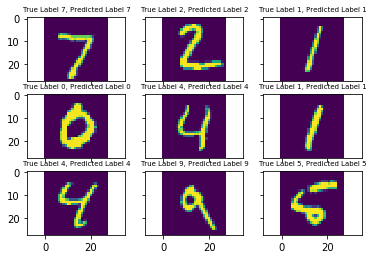

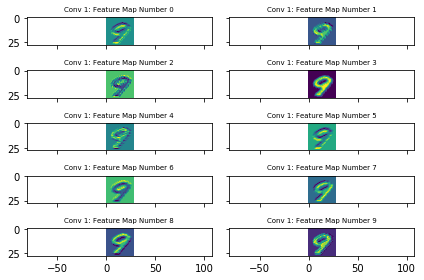

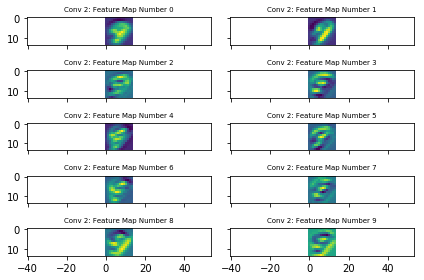

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Input variables (place holders), images (input x) and y_ (labels)
x = tf.placeholder(tf.float32, shape=[None, 784])
images = tf.reshape(x, [-1, 28, 28, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# First convolutional layer (conv1) and max_pooling layer (pool1)
# Number of filters is assumed to be 10
# w_1 is initialized by glorot_uniform (default function)
w_1 = tf.get_variable(name="w_1_MNIST", shape=[3, 3, 1, 10])
b_1 = tf.get_variable(name='b_1_MNIST', shape=[10], initializer=tf.constant_initializer(0.0))
conv_firstLayer = tf.nn.conv2d(images, w_1, strides=[1, 1, 1, 1], padding='SAME')

pre_activation = tf.nn.bias_add(conv_firstLayer, b_1)
conv1 = tf.nn.relu(pre_activation)
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Second convolutional layer (conv2) and max_pooling layer (pool2)
# Number of filters is assumed to be 10
# w_2 is initialized by glorot_uniform (default function)
w_2 = tf.get_variable(name="w_2_MNIST", shape=[5, 5, 10, 10])
b_2 = tf.get_variable(name='b_2_MNIST', shape=[10], initializer=tf.constant_initializer(0.0))
conv_secondLayer = tf.nn.conv2d(pool1, w_2, strides=[1, 1, 1, 1], padding='SAME')
pre_activation = tf.nn.bias_add(conv_secondLayer, b_2)
conv2 = tf.nn.relu(pre_activation)
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Flatten the pool2 layer

flatten = tf.contrib.layers.flatten(pool2)

# Fully connected layer

w_fc1 = tf.get_variable('w_fc1_MNIST', shape=[flatten.get_shape()[1], 1024])
b_fc1 = tf.get_variable('b_fc1_MNIST', shape=[1024])

fc1 = tf.nn.relu(tf.matmul(flatten, w_fc1) + b_fc1)

# Output layer
w_fc2 = tf.get_variable('w_fc2_MNIST', shape=[1024, 10])
b_fc2 = tf.get_variable('b_fc2_MNIST', shape=[10])

y = tf.matmul(fc1, w_fc2) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

# Training model
# Use Adam as the optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluate model
# Accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# This is for part 3 and predicting the labels of 9 image examples
prediction_samples = tf.argmax(y, 1)

# Training Hyper-parameters
batch_size = 100
no_epochs = 1

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  num_examples = 0
  for i in range(550):
    batch = mnist.train.next_batch(batch_size)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    if num_examples % 10000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        print('After training %d examples, training accuracy %g' % (num_examples, train_accuracy))
    num_examples += batch_size

  print('Test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels}))

  # Predict labels for the first 9 examples of test images.
  predicted_labels = prediction_samples.eval(feed_dict={x: mnist.test.images[0:9]})
  # Plot the 9 images with their true and predicted labels
  dat = mnist.test.images[0:9]
  dat = np.reshape(dat, (9, 28, 28))
  labels = mnist.test.labels[0:9]
  labels = np.argmax(labels, axis=1)
  fig, ax = plt.subplots(nrows=3, ncols=3, sharex='all', sharey='all')
  i = 0
  for row in ax:
      for col in row:
          plt.figure(1, figsize=(8, 6))
          col.imshow(dat[i])
          TrueLabel = labels[i]
          col.set_title('True Label {}, Predicted Label {}'.format(TrueLabel, predicted_labels[i]), fontsize=7)
          i += 1

  # Visualize all the feature maps (i.e., 10) of the first and second layer of convolutional layers for one image.
  # The image is the last example in the training process
  # Feature maps in the first layer
  image = np.reshape(batch[0][-1], [-1, 784])
  conv_firstLayer = conv_firstLayer.eval(feed_dict={x: image})
  conv_firstLayer = np.transpose(conv_firstLayer[0], [2, 0, 1])
  fig, ax = plt.subplots(nrows=5, ncols=2, sharex='all', sharey='all')
  i = 0
  for row in ax:
      for col in row:
          plt.figure(2)
          col.imshow(conv_firstLayer[i])
          col.set_title('Conv 1: Feature Map Number {}'.format(i), fontsize=10)
          i += 1
  fig.tight_layout()

  # Feature maps in the second layer
  conv_secondLayer = conv_secondLayer.eval(feed_dict={x: image})
  conv_secondLayer = np.transpose(conv_secondLayer[0], [2, 0, 1])
  fig, ax = plt.subplots(nrows=5, ncols=2, sharex='all', sharey='all')
  i = 0
  for row in ax:
      for col in row:
          plt.figure(3)
          col.imshow(conv_secondLayer[i])
          col.set_title('Conv 2: Feature Map Number {}'.format(i), fontsize=10)
          i += 1
  fig.tight_layout()

plt.show()


Question 2, CIFAR100 dataset

The flow and order of the code is as follows: 1) importing CIFAR100 dataset, 2) Creating CNN model, 3) Training CNN model, 4) Calculating and printing training and test accuracy, 5) Ploting 9 sample images and their corresponding true and predicted labels, 6) Ploting feature maps of the first convolutional layer for one image, 7) Ploting feature maps of the second convolutional layer for one image, 8) Ploting the filters of the first convolutional layer. 

Attention Notes:  1) Before every step, I commented to elaborate more, 2) I loaded the dataset by downloading from the original website, 3) Due to low power of my computer, I used only one epoch for training. So the accuracy may not be as high as possible. 3) The images are already blurred. I tried different ways to plot clear images. Yet it seems the images have been already blurred. 

After training 10000 examples, training accuracy 0.07
After training 20000 examples, training accuracy 0.18
After training 30000 examples, training accuracy 0.13
After training 40000 examples, training accuracy 0.18
After training 50000 examples, training accuracy 0.16
Test accuracy 0.1397


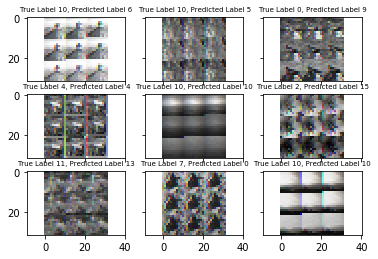

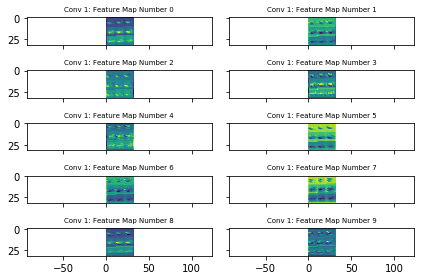

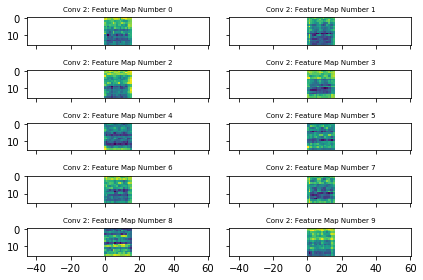

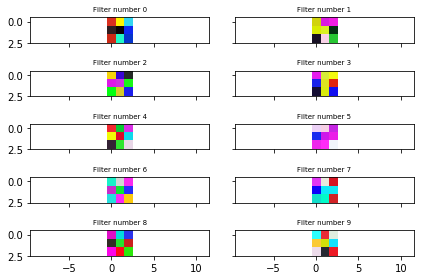

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load CIFAR10 Data
train = unpickle('train')
training_file_names = ['train']
training_files = []
[training_files.append(unpickle(file)) for file in training_file_names]
test_file = unpickle('test')


# Input variables (place holders), images (input x) and y_ (labels)
x = tf.placeholder(tf.float32, shape=[None, 3072])
images = tf.reshape(x, [-1, 32, 32, 3])
A = images.get_shape()

y_ = tf.placeholder(tf.float32, shape=[None, 100])

# First convolutional layer (conv1) and max_pooling layer (pool1)
# Number of filters is assumed to be 10
# w_1 is initialized by glorot_uniform (default function)
w_1 = tf.get_variable(name="w_1_CIFAR", shape=[3, 3, 3, 10])
b_1 = tf.get_variable(name='b_1_CIFAR', shape=[10], initializer=tf.constant_initializer(0.0))
conv_firstLayer = tf.nn.conv2d(images, w_1, strides=[1, 1, 1, 1], padding='SAME')
pre_activation = tf.nn.bias_add(conv_firstLayer, b_1)
conv1 = tf.nn.relu(pre_activation)
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Second convolutional layer (conv2) and max_pooling layer (pool2)
# Number of filters is assumed to be 10
# w_2 is initialized by glorot_uniform (default function)
w_2 = tf.get_variable(name="w_2_CIFAR", shape=[5, 5, 10, 10])
b_2 = tf.get_variable(name='b_2_CIFAR', shape=[10], initializer=tf.constant_initializer(0.0))
conv_secondLayer = tf.nn.conv2d(pool1, w_2, strides=[1, 1, 1, 1], padding='SAME')
pre_activation = tf.nn.bias_add(conv_secondLayer, b_2)
conv2 = tf.nn.relu(pre_activation)
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Flatten the pool2 layer

flatten = tf.contrib.layers.flatten(pool2)

# Fully connected layer

w_fc1 = tf.get_variable('w_fc1_CIFAR', shape=[flatten.get_shape()[1], 1024])
b_fc1 = tf.get_variable('b_fc1_CIFAR', shape=[1024])

fc1 = tf.nn.relu(tf.matmul(flatten, w_fc1) + b_fc1)

# Output layer
w_fc2 = tf.get_variable('w_fc2_CIFAR', shape=[1024, 100])
b_fc2 = tf.get_variable('b_fc2_CIFAR', shape=[100])

y = tf.matmul(fc1, w_fc2) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

# Training model
# Use Adam as the optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluate model
# Accuracy

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# This is for part 3 and predicting the labels of 9 image examples
prediction_samples = tf.argmax(y, 1)

# Training Hyper-parameters
batch_size = 100
no_epochs = 1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(no_epochs):
        for file in training_files:
            data = file[b'data']
            labels = file[b'coarse_labels']
            counter = 0
            for i in range(int(50000/batch_size)):
                # labels are first converted to one-hot vector
                Y_ = tf.one_hot(labels[counter: counter + batch_size], depth=100).eval()
                X = data[counter: counter + batch_size]
                train_step.run(feed_dict={x: X, y_: Y_})
                counter += batch_size
                if counter % 10000 == 0:
                    train_accuracy = accuracy.eval(
                        feed_dict={x: X, y_: Y_})
                    print('After training %d examples, training accuracy %g' % (counter, train_accuracy))

    # Test accuracy
    Y_ = tf.one_hot(test_file[b'coarse_labels'], depth=100).eval()
    X = test_file[b'data']
    print('Test accuracy %g' % accuracy.eval(feed_dict={x: X, y_: Y_}))

    # Predict labels for the first 9 examples of test images.
    predicted_labels = prediction_samples.eval(feed_dict={x: test_file[b'data'][0:9]})
    # Plot the 9 images with their true and predicted labels
    dat = test_file[b'data'][0:9]
    dat = np.reshape(dat, (9, 32, 32, 3))
    labels = test_file[b'coarse_labels'][0:9]
    fig, ax = plt.subplots(nrows=3, ncols=3, sharex='all', sharey='all')

    i = 0
    for row in ax:
        for col in row:
            plt.figure(1)
            col.imshow(dat[i])
            TrueLabel = labels[i]
            col.set_title('True Label {}, Predicted Label {}'.format(TrueLabel, predicted_labels[i]), fontsize=7)
            i += 1


    # Visualize all the feature maps (i.e., 10) of the first and second layer of convolutional layers for one image
    # The image is the last example in the training set
    # Feature maps in the first layer
    image = np.reshape(data[-1], [-1, 3072])
    conv_firstLayer = conv_firstLayer.eval(feed_dict={x: image})
    conv_firstLayer = np.transpose(conv_firstLayer[0], [2, 0, 1])
    fig, ax = plt.subplots(nrows=5, ncols=2, sharex='all', sharey='all')
    i = 0
    for row in ax:
        for col in row:
            plt.figure(2)
            col.imshow(conv_firstLayer[i])
            col.set_title('Conv 1: Feature Map Number {}'.format(i), fontsize=7)
            i += 1
    fig.tight_layout()

    # Feature maps in the second layer
    conv_secondLayer = conv_secondLayer.eval(feed_dict={x: image})
    conv_secondLayer = np.transpose(conv_secondLayer[0], [2, 0, 1])
    fig, ax = plt.subplots(nrows=5, ncols=2, sharex='all', sharey='all')
    i = 0
    for row in ax:
        for col in row:
            plt.figure(3)
            col.imshow(conv_secondLayer[i])
            col.set_title('Conv 2: Feature Map Number {}'.format(i), fontsize=7)
            i += 1
    fig.tight_layout()

    # Filters in the first layer
    w_1 = w_1.eval()
    fig, ax = plt.subplots(nrows=5, ncols=2, sharex='all', sharey='all')
    i = 0
    for row in ax:
        for col in row:
            plt.figure(4)
            col.imshow(w_1[:, :, :, i])
            col.set_title('Filter number {}'.format(i), fontsize=7)
            i += 1
    fig.tight_layout()
    
plt.show()

Question 2, RNN models

The flow and order of the code is as follows: 1) importing the train and test datasets, 2) Cleaning the sentences in both datasets, 3) Creating training and test embedding matrix for all examples, 4) Creating the RNN models. In this step, we use three different types of RNN: vanilla RNN, LSTM, GRU. Each of these models are run in a separate cell as follows. 5) Calculating and printing training and test accuracy.

Attention Notes:  1) Before every step, I commented to elaborate more, 3) Due to low power of my computer, I used only one epoch for training. So the accuracy may not be as high as possible, 4) I got help from https://www.oreilly.com for building my model. 5) I also used a drop out layer after the RNN layer. 

Comparing the reults of different RNN models: 
Vanilla RNN: Train Accuracy after one epoch: 0.62, Test Accuracy:0.52
LSTM: Train Accuracy after one epoch:0.71 , Test Accuracy:0.68
GRU: Train Accuracy after one epoch:0.73, Test Accuracy:0.68

According to the above results, LSTM and GRU work better than vanilla RNN. This was expected as the LSTM adn GRU have more controls on passing and storing inforamtion between the repeating modules in the RNN layer. 

In [1]:
# Vanilla RNN model
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import re

# Load data and prepare the input layers.
with open('test.csv', 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    test_sentence = []
    test_label = []
    for row in reader:
        test_sentence.append(row[1])
        if row[0] == 'postive':
            test_label.append([1, 0])
        else:
            test_label.append([0, 1])

test_label = np.array(test_label, dtype=int)

with open('train.csv', 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    train_sentence = []
    train_label = []
    for row in reader:
        train_sentence.append(row[1])
        if row[0] == 'postive':
            train_label.append([1, 0])
        else:
            train_label.append([0, 1])

train_label = np.array(train_label, dtype=int)

# Although it seems the sentences are clean in trained and test data, I applied a cleaning process to remove
# any punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
# All words also are converted to a lower case.
remove_special_chars = re.compile("[^A-Za-z0-9 ]+")


def clean(sentence):
    return re.sub(remove_special_chars, "", sentence.lower())

# Create a data frame for wordVectors using the word-vectors.txt file for both train and test sets.
# Embedding matrix: the word vectors of all words in a sentences over all sentences.
wordVectors = pd.read_csv('word-vectors.txt', index_col=0, header=None)
max_words = 100
word_dim = 50
train_embedding_matrix = np.zeros((len(train_sentence), max_words, word_dim), dtype=np.float32)

for i in range(len(train_sentence)):
    indexCounter = 0
    clean_sentence = clean(train_sentence[i])
    split_sentence = clean_sentence.split()
    for word in split_sentence:
        try:
            train_embedding_matrix[i, indexCounter, :] = wordVectors.loc[word]
        except KeyError:
            pass
        indexCounter = indexCounter + 1
        if indexCounter >= max_words:
            break

test_embedding_matrix = np.zeros((len(test_sentence), max_words, word_dim), dtype=np.float32)
for i in range(len(test_sentence)):
    indexCounter = 0
    clean_sentence = clean(test_sentence[i])
    split_sentence = clean_sentence.split()
    for word in split_sentence:
        try:
            test_embedding_matrix[i, indexCounter, :] = wordVectors.loc[word]
        except KeyError:
            pass
        indexCounter = indexCounter + 1
        if indexCounter >= max_words:
            break

# Creating the vanilla RNN, LSTM, GRU models
# Specifying hyper-parameters
batchSize = 100
Units = 64  # number of units in RNNs
numClasses = 2
epoch = 1

# Input variables (place holders), wordVectors of a sentence (input x) and y_ (labels)
x = tf.placeholder(dtype=tf.float32, shape=[None, max_words, word_dim])
y_ = tf.placeholder(dtype=tf.float32, shape=[None, numClasses])


RNNCell = tf.nn.rnn_cell.BasicRNNCell(Units)
RNNCell = tf.contrib.rnn.DropoutWrapper(cell=RNNCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(RNNCell, x, dtype=tf.float32)

# output layer for classification task
weight_ = tf.Variable(tf.truncated_normal([Units, numClasses]))
# weight = tf.get_variable('w_output', shape=[lstmUnits, numClasses])
bias_ = tf.Variable(tf.constant(0.1, shape=[numClasses]))
# bias = tf.get_variable('bias', shape=[numClasses], initializer=tf.constant_initializer(0.1))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight_) + bias_)


# Training model
# Use Adam as the optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

# Evaluate model
# Accuracy
correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train the model over number epochs and batch size
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for k in range(epoch):
      counter = 0
      for i in range(int(len(train_sentence)/batchSize)):
          nextBatch = train_embedding_matrix[counter:counter+batchSize, :]
          nextBatch_label = train_label[counter: counter+batchSize, :]
          train_step.run(feed_dict={x: nextBatch, y_: nextBatch_label})
          counter += batchSize
          if counter % 5000 ==0:
              train_accuracy = accuracy.eval(feed_dict={x: nextBatch, y_: nextBatch_label})
              print('After training %d examples, training accuracy %g' % (counter, train_accuracy))
          

  print('Test accuracy %g' % accuracy.eval(feed_dict={
      x: test_embedding_matrix, y_: test_label}))


c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


After training 5000 examples, training accuracy 0.5
After training 10000 examples, training accuracy 0.52
After training 15000 examples, training accuracy 0.52
After training 20000 examples, training accuracy 0.62
Test accuracy 0.5174


In [3]:
# LSTM model
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import re

# Load data and prepare the input layers.
with open('test.csv', 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    test_sentence = []
    test_label = []
    for row in reader:
        test_sentence.append(row[1])
        if row[0] == 'postive':
            test_label.append([1, 0])
        else:
            test_label.append([0, 1])

test_label = np.array(test_label, dtype=int)

with open('train.csv', 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    train_sentence = []
    train_label = []
    for row in reader:
        train_sentence.append(row[1])
        if row[0] == 'postive':
            train_label.append([1, 0])
        else:
            train_label.append([0, 1])

train_label = np.array(train_label, dtype=int)

# Although it seems the sentences are clean in trained and test data, I applied a cleaning process to remove
# any punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
# All words also are converted to a lower case.
remove_special_chars = re.compile("[^A-Za-z0-9 ]+")


def clean(sentence):
    return re.sub(remove_special_chars, "", sentence.lower())

# Create a data frame for wordVectors using the word-vectors.txt file for both train and test sets.
# Embedding matrix: the word vectors of all words in a sentences over all sentences.
wordVectors = pd.read_csv('word-vectors.txt', index_col=0, header=None)
max_words = 100
word_dim = 50
train_embedding_matrix = np.zeros((len(train_sentence), max_words, word_dim), dtype=np.float32)

for i in range(len(train_sentence)):
    indexCounter = 0
    clean_sentence = clean(train_sentence[i])
    split_sentence = clean_sentence.split()
    for word in split_sentence:
        try:
            train_embedding_matrix[i, indexCounter, :] = wordVectors.loc[word]
        except KeyError:
            pass
        indexCounter = indexCounter + 1
        if indexCounter >= max_words:
            break

test_embedding_matrix = np.zeros((len(test_sentence), max_words, word_dim), dtype=np.float32)
for i in range(len(test_sentence)):
    indexCounter = 0
    clean_sentence = clean(test_sentence[i])
    split_sentence = clean_sentence.split()
    for word in split_sentence:
        try:
            test_embedding_matrix[i, indexCounter, :] = wordVectors.loc[word]
        except KeyError:
            pass
        indexCounter = indexCounter + 1
        if indexCounter >= max_words:
            break

# Creating the vanilla RNN, LSTM, GRU models
# Specifying hyper-parameters
batchSize = 100
Units = 64  # number of units in RNNs
numClasses = 2
epoch = 1

# Input variables (place holders), wordVectors of a sentence (input x) and y_ (labels)
x = tf.placeholder(dtype=tf.float32, shape=[None, max_words, word_dim])
y_ = tf.placeholder(dtype=tf.float32, shape=[None, numClasses])


RNNCell = tf.contrib.rnn.BasicLSTMCell(Units)
RNNCell = tf.contrib.rnn.DropoutWrapper(cell=RNNCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(RNNCell, x, dtype=tf.float32)

# output layer for classification task
weight = tf.Variable(tf.truncated_normal([Units, numClasses]))
# weight = tf.get_variable('w_output', shape=[lstmUnits, numClasses])
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
# bias = tf.get_variable('bias', shape=[numClasses], initializer=tf.constant_initializer(0.1))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)


# Training model
# Use Adam as the optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

# Evaluate model
# Accuracy
correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train the model over number epochs and batch size
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for k in range(epoch):
      counter = 0
      for i in range(int(len(train_sentence)/batchSize)):
          nextBatch = train_embedding_matrix[counter:counter+batchSize, :]
          nextBatch_label = train_label[counter: counter+batchSize, :]
          train_step.run(feed_dict={x: nextBatch, y_: nextBatch_label})
          counter += batchSize
          if counter % 5000 == 0:
              train_accuracy = accuracy.eval(feed_dict={x: nextBatch, y_: nextBatch_label})
              print('After training %d examples, training accuracy %g' % (counter, train_accuracy))
          

  print('Test accuracy %g' % accuracy.eval(feed_dict={
      x: test_embedding_matrix, y_: test_label}))


c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


After training 5000 examples, training accuracy 0.62
After training 10000 examples, training accuracy 0.57
After training 15000 examples, training accuracy 0.54
After training 20000 examples, training accuracy 0.71
Test accuracy 0.6782


In [4]:
# GRU model
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import re

# Load data and prepare the input layers.
with open('test.csv', 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    test_sentence = []
    test_label = []
    for row in reader:
        test_sentence.append(row[1])
        if row[0] == 'postive':
            test_label.append([1, 0])
        else:
            test_label.append([0, 1])

test_label = np.array(test_label, dtype=int)

with open('train.csv', 'r', encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    train_sentence = []
    train_label = []
    for row in reader:
        train_sentence.append(row[1])
        if row[0] == 'postive':
            train_label.append([1, 0])
        else:
            train_label.append([0, 1])

train_label = np.array(train_label, dtype=int)

# Although it seems the sentences are clean in trained and test data, I applied a cleaning process to remove
# any punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
# All words also are converted to a lower case.
remove_special_chars = re.compile("[^A-Za-z0-9 ]+")


def clean(sentence):
    return re.sub(remove_special_chars, "", sentence.lower())

# Create a data frame for wordVectors using the word-vectors.txt file for both train and test sets.
# Embedding matrix: the word vectors of all words in a sentences over all sentences.
wordVectors = pd.read_csv('word-vectors.txt', index_col=0, header=None)
max_words = 100
word_dim = 50
train_embedding_matrix = np.zeros((len(train_sentence), max_words, word_dim), dtype=np.float32)

for i in range(len(train_sentence)):
    indexCounter = 0
    clean_sentence = clean(train_sentence[i])
    split_sentence = clean_sentence.split()
    for word in split_sentence:
        try:
            train_embedding_matrix[i, indexCounter, :] = wordVectors.loc[word]
        except KeyError:
            pass
        indexCounter = indexCounter + 1
        if indexCounter >= max_words:
            break

test_embedding_matrix = np.zeros((len(test_sentence), max_words, word_dim), dtype=np.float32)
for i in range(len(test_sentence)):
    indexCounter = 0
    clean_sentence = clean(test_sentence[i])
    split_sentence = clean_sentence.split()
    for word in split_sentence:
        try:
            test_embedding_matrix[i, indexCounter, :] = wordVectors.loc[word]
        except KeyError:
            pass
        indexCounter = indexCounter + 1
        if indexCounter >= max_words:
            break

# Creating the vanilla RNN, LSTM, GRU models
# Specifying hyper-parameters
batchSize = 100
Units = 64  # number of units in RNNs
numClasses = 2
epoch = 1

# Input variables (place holders), wordVectors of a sentence (input x) and y_ (labels)
x = tf.placeholder(dtype=tf.float32, shape=[None, max_words, word_dim])
y_ = tf.placeholder(dtype=tf.float32, shape=[None, numClasses])

RNNCell = tf.contrib.rnn.GRUCell(Units)
RNNCell = tf.contrib.rnn.DropoutWrapper(cell=RNNCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(RNNCell, x, dtype=tf.float32)

# output layer for classification task
weight = tf.Variable(tf.truncated_normal([Units, numClasses]))
# weight = tf.get_variable('w_output', shape=[lstmUnits, numClasses])
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
# bias = tf.get_variable('bias', shape=[numClasses], initializer=tf.constant_initializer(0.1))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)


# Training model
# Use Adam as the optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

# Evaluate model
# Accuracy
correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train the model over number epochs and batch size
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for k in range(epoch):
      counter = 0
      for i in range(int(len(train_sentence)/batchSize)):
          nextBatch = train_embedding_matrix[counter:counter+batchSize, :]
          nextBatch_label = train_label[counter: counter+batchSize, :]
          train_step.run(feed_dict={x: nextBatch, y_: nextBatch_label})
          counter += batchSize
          if counter % 5000 == 0:
              train_accuracy = accuracy.eval(feed_dict={x: nextBatch, y_: nextBatch_label})
              print('After training %d examples, training accuracy %g' % (counter, train_accuracy))
          

  print('Test accuracy %g' % accuracy.eval(feed_dict={
      x: test_embedding_matrix, y_: test_label}))


c:\users\sina\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


After training 5000 examples, training accuracy 0.57
After training 10000 examples, training accuracy 0.57
After training 15000 examples, training accuracy 0.58
After training 20000 examples, training accuracy 0.73
Test accuracy 0.6836
